In [1]:
import os
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt

from PIL import Image
from fastprogress import progress_bar
from auto_encoder import encode_images, decode_images

od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small")

Skipping, found downloaded files in "./fashion-product-images-small" (use force=True to force download)


In [2]:
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, root="fashion-product-images-small", size=(64, 64)):
        metadata = pd.read_csv(os.path.join(root, "styles.csv"), on_bad_lines='skip')
        # check if images exist
        metadata['exists'] = metadata['id'].apply(lambda id: os.path.exists(os.path.join(root, "images", f"{id}.jpg")))
        metadata = metadata[metadata['exists']]
        # extract classes
        classes = metadata['subCategory'].values.tolist()
        classes = list(set(classes))
        self.classes = { category: idx  for idx, category in enumerate(classes) }
        # extract image file names
        self.image_files = metadata['id'].apply(lambda id: os.path.join(root, "images", f"{id}.jpg")).values
        # extract image labels
        self.image_labels = metadata['subCategory'].apply(lambda x: self.classes[x]).values
        self.size = size
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # image label
        label = torch.tensor(self.image_labels[idx], dtype=torch.int64)
        # load image file
        image = Image.open(self.image_files[idx]).convert('RGB')
        image = image.resize(self.size)
        image = np.array(image)
        # format to (channel, width, height)
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        # normalize image
        image = (image / 127.5) - 1

        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


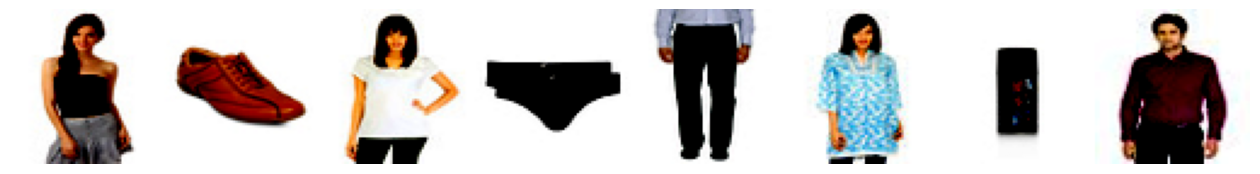

In [3]:
# load dataset
train_dataset = FashionDataset(root="fashion-product-images-small", size=(64, 64))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# extract a batch of images
batch_images, batch_labels = next(iter(train_loader))
# display a grid of images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch_images[:8], padding=0).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

#### Load Auto-Encoder

In [4]:
sample_latent = encode_images(batch_images)
print('Latent image shape:', sample_latent.shape)

Latent image shape: torch.Size([256, 4, 16, 16])


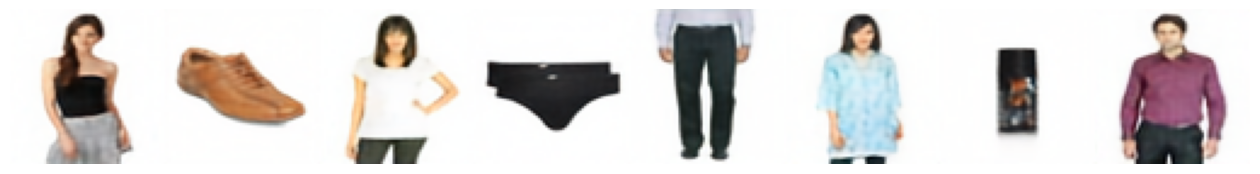

In [5]:
sample_reconstruction = decode_images(sample_latent)
sample_reconstruction = (sample_reconstruction.clamp(-1, 1) + 1) / 2
sample_reconstruction = (sample_reconstruction * 255).type(torch.uint8)

# display a reconstructed images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_reconstruction[:8], padding=0).cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

#### Attention Block

In [6]:
class SelfAttention(torch.nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = torch.nn.MultiheadAttention(channels, num_heads=1, batch_first=True)
        self.ln = torch.nn.LayerNorm([channels])
        self.ff_self = torch.nn.Sequential(
            torch.nn.LayerNorm([channels]),
            torch.nn.Linear(channels, channels),
            torch.nn.GELU(),
            torch.nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

#### Residual Blocks

In [7]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.GroupNorm(1, mid_channels),
            torch.nn.GELU(),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.GroupNorm(1, out_channels)
        )

    def forward(self, x):
        if self.residual:
            return torch.nn.functional.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [8]:
class Down(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.max_pool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels)
        )

        self.emb_layer = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, t):
        x = self.max_pool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [9]:
class Up(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = torch.nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = torch.nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2)
        )

        self.emb_layer = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

#### U-Net Transformer

In [10]:
class UNetTransformer(torch.nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None):
        super().__init__()
        # embeddings
        self.time_dim = time_dim
        self.label_emb = torch.nn.Embedding(num_classes, time_dim)
        # encoder
        self.inc = DoubleConv(c_in, 128)
        self.down1 = Down(128, 256)
        self.sa1 = SelfAttention(256)
        self.down2 = Down(256, 256)
        self.sa2 = SelfAttention(256)
        # bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 256)
        # decoder
        self.up1 = Up(512, 128)
        self.sa3 = SelfAttention(128)
        self.up2 = Up(256, 128)
        self.sa4 = SelfAttention(128)
        self.out_c = torch.nn.Conv2d(128, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float().cuda() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y=None):
        # time embedding
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        # label embedding
        if y is not None:
            t += self.label_emb(y)
        # encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        # bottleneck
        x3 = self.bot1(x3)
        x3 = self.bot2(x3)
        # decoder
        x = self.up1(x3, x2, t)
        x = self.sa3(x)
        x = self.up2(x, x1, t)
        x = self.sa4(x)
        output = self.out_c(x)

        return output

In [11]:
# model initializations
model = UNetTransformer(c_in=4, c_out=4, num_classes=len(train_dataset.classes)).cuda()
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

In [12]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18016516

In [13]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [14]:
# hyperparameters
noise_steps = 1000
beta_start = 1e-4
beta_end = 0.02
img_size = 16
total_epochs = 100
learning_rate = 5e-3
log_every_epoch = 10

In [15]:
beta = torch.linspace(beta_start, beta_end, noise_steps).cuda()
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

def noise_images(x, t):
    eps = torch.randn_like(x)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]

    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=total_epochs)
ema = EMA(0.995)
scaler = torch.cuda.amp.GradScaler()

In [17]:
def save_checkpoint(checkpoint_path="sub_diffusion_models"):
    torch.save(model.state_dict(), os.path.join(checkpoint_path, "ckpt.pt"))
    torch.save(ema_model.state_dict(), os.path.join(checkpoint_path, "ema_ckpt.pt"))
    
def load_models(checkpoint_path="sub_diffusion_models"):
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, "ckpt.pt")))
    ema_model.load_state_dict(torch.load(os.path.join(checkpoint_path, "ema_ckpt.pt")))

def generate_samples(labels, cfg_scale=3):
    ema_model.eval()
    x = torch.randn((len(labels), 4, img_size, img_size)).cuda()
    for i in progress_bar(reversed(range(1, noise_steps)), total=noise_steps-1, leave=False):
        t = torch.full((len(labels),), i).long().cuda()
        predicted_noise = ema_model(x, t, labels)
        if cfg_scale > 0:
            unconditional_noise = ema_model(x, t, None)
            predicted_noise = torch.lerp(unconditional_noise, predicted_noise, cfg_scale)

        sample_alpha = alpha[t][:, None, None, None]
        sample_alpha_hat = alpha_hat[t][:, None, None, None]
        sample_beta = beta[t][:, None, None, None]
        sample_noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)

        x = 1 / torch.sqrt(sample_alpha) * (x - ((1 - sample_alpha) / (torch.sqrt(1 - sample_alpha_hat))) * predicted_noise) + torch.sqrt(sample_beta) * sample_noise
    # rescale generated image
    x = decode_images(x)
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

def log_samples():
    labels = torch.randint(0, len(train_dataset.classes), (16,)).long().cuda()
    sample_grid = generate_samples(labels)
    sample_grid = torchvision.utils.make_grid(sample_grid, nrow=4)

    plt.imshow(sample_grid.cpu().permute(1, 2, 0).numpy(), vmin=0., vmax=1.)
    plt.axis('off')
    plt.show()

Epoch: 1/100 - loss: 4.68e+01, learning_rate: 2.13e-04


Epoch: 2/100 - loss: 1.63e+01, learning_rate: 2.52e-04


Epoch: 3/100 - loss: 1.24e+01, learning_rate: 3.18e-04


Epoch: 4/100 - loss: 1.16e+01, learning_rate: 4.08e-04


Epoch: 5/100 - loss: 1.06e+01, learning_rate: 5.22e-04


Epoch: 6/100 - loss: 1.00e+01, learning_rate: 6.59e-04


Epoch: 7/100 - loss: 9.45e+00, learning_rate: 8.17e-04


Epoch: 8/100 - loss: 9.29e+00, learning_rate: 9.94e-04


Epoch: 9/100 - loss: 9.24e+00, learning_rate: 1.19e-03


Epoch: 10/100 - loss: 8.87e+00, learning_rate: 1.40e-03


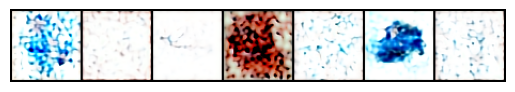

Epoch: 11/100 - loss: 8.65e+00, learning_rate: 1.62e-03


Epoch: 12/100 - loss: 8.61e+00, learning_rate: 1.86e-03


Epoch: 13/100 - loss: 8.31e+00, learning_rate: 2.10e-03


Epoch: 14/100 - loss: 8.21e+00, learning_rate: 2.35e-03


Epoch: 15/100 - loss: 8.07e+00, learning_rate: 2.60e-03


Epoch: 16/100 - loss: 8.00e+00, learning_rate: 2.85e-03


Epoch: 17/100 - loss: 7.83e+00, learning_rate: 3.10e-03


Epoch: 18/100 - loss: 2.70e+02, learning_rate: 3.34e-03


Epoch: 19/100 - loss: 1.74e+02, learning_rate: 3.58e-03


Epoch: 20/100 - loss: 1.74e+02, learning_rate: 3.80e-03


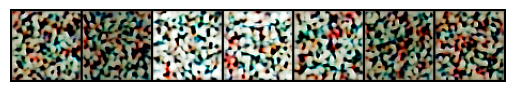

Epoch: 21/100 - loss: 1.74e+02, learning_rate: 4.01e-03


Epoch: 22/100 - loss: 1.74e+02, learning_rate: 4.21e-03


Epoch: 23/100 - loss: 1.74e+02, learning_rate: 4.38e-03


Epoch: 24/100 - loss: 1.73e+02, learning_rate: 4.54e-03


Epoch: 25/100 - loss: 1.42e+02, learning_rate: 4.68e-03


Epoch: 26/100 - loss: 6.19e+01, learning_rate: 4.79e-03


Epoch: 27/100 - loss: 1.54e+01, learning_rate: 4.88e-03


Epoch: 28/100 - loss: 1.23e+01, learning_rate: 4.95e-03


Epoch: 29/100 - loss: 1.25e+01, learning_rate: 4.99e-03


Epoch: 30/100 - loss: 1.13e+01, learning_rate: 5.00e-03


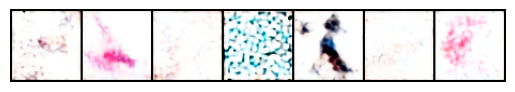

Epoch: 31/100 - loss: 1.12e+01, learning_rate: 5.00e-03


Epoch: 32/100 - loss: 1.06e+01, learning_rate: 4.99e-03


Epoch: 33/100 - loss: 1.02e+01, learning_rate: 4.98e-03


Epoch: 34/100 - loss: 1.23e+01, learning_rate: 4.96e-03


Epoch: 35/100 - loss: 1.08e+01, learning_rate: 4.94e-03


Epoch: 36/100 - loss: 1.02e+01, learning_rate: 4.91e-03


Epoch: 37/100 - loss: 1.03e+01, learning_rate: 4.88e-03


Epoch: 38/100 - loss: 9.86e+00, learning_rate: 4.84e-03


Epoch: 39/100 - loss: 9.71e+00, learning_rate: 4.80e-03


Epoch: 40/100 - loss: 9.32e+00, learning_rate: 4.75e-03


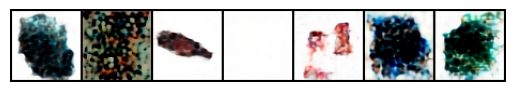

Epoch: 41/100 - loss: 9.06e+00, learning_rate: 4.70e-03


Epoch: 42/100 - loss: 9.16e+00, learning_rate: 4.65e-03


Epoch: 43/100 - loss: 8.91e+00, learning_rate: 4.59e-03


Epoch: 44/100 - loss: 8.61e+00, learning_rate: 4.52e-03


Epoch: 45/100 - loss: 8.75e+00, learning_rate: 4.45e-03


Epoch: 46/100 - loss: 8.51e+00, learning_rate: 4.38e-03


Epoch: 47/100 - loss: 8.52e+00, learning_rate: 4.31e-03


Epoch: 48/100 - loss: 8.05e+00, learning_rate: 4.23e-03


Epoch: 49/100 - loss: 8.18e+00, learning_rate: 4.14e-03


Epoch: 50/100 - loss: 8.01e+00, learning_rate: 4.06e-03


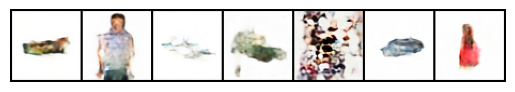

Epoch: 51/100 - loss: 7.88e+00, learning_rate: 3.97e-03


Epoch: 52/100 - loss: 7.69e+00, learning_rate: 3.88e-03


Epoch: 53/100 - loss: 7.77e+00, learning_rate: 3.78e-03


Epoch: 54/100 - loss: 7.57e+00, learning_rate: 3.68e-03


Epoch: 55/100 - loss: 7.53e+00, learning_rate: 3.58e-03


Epoch: 56/100 - loss: 7.43e+00, learning_rate: 3.48e-03


Epoch: 57/100 - loss: 7.28e+00, learning_rate: 3.38e-03


Epoch: 58/100 - loss: 7.18e+00, learning_rate: 3.27e-03


Epoch: 59/100 - loss: 7.34e+00, learning_rate: 3.16e-03


Epoch: 60/100 - loss: 7.32e+00, learning_rate: 3.06e-03


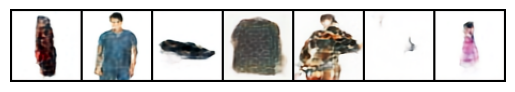

Epoch: 61/100 - loss: 7.18e+00, learning_rate: 2.95e-03


Epoch: 62/100 - loss: 7.16e+00, learning_rate: 2.83e-03


Epoch: 63/100 - loss: 7.11e+00, learning_rate: 2.72e-03


Epoch: 64/100 - loss: 7.02e+00, learning_rate: 2.61e-03


Epoch: 65/100 - loss: 7.03e+00, learning_rate: 2.50e-03


Epoch: 66/100 - loss: 6.96e+00, learning_rate: 2.39e-03


Epoch: 67/100 - loss: 6.85e+00, learning_rate: 2.28e-03


Epoch: 68/100 - loss: 6.88e+00, learning_rate: 2.16e-03


Epoch: 69/100 - loss: 6.68e+00, learning_rate: 2.05e-03


Epoch: 70/100 - loss: 6.80e+00, learning_rate: 1.94e-03


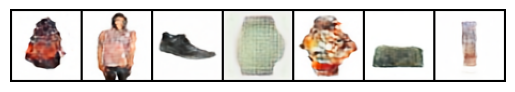

Epoch: 71/100 - loss: 6.66e+00, learning_rate: 1.83e-03


Epoch: 72/100 - loss: 6.86e+00, learning_rate: 1.73e-03


Epoch: 73/100 - loss: 6.62e+00, learning_rate: 1.62e-03


Epoch: 74/100 - loss: 6.63e+00, learning_rate: 1.52e-03


Epoch: 75/100 - loss: 6.62e+00, learning_rate: 1.41e-03


Epoch: 76/100 - loss: 6.51e+00, learning_rate: 1.31e-03


Epoch: 77/100 - loss: 6.58e+00, learning_rate: 1.22e-03


Epoch: 78/100 - loss: 6.57e+00, learning_rate: 1.12e-03


Epoch: 79/100 - loss: 6.47e+00, learning_rate: 1.03e-03


Epoch: 80/100 - loss: 6.42e+00, learning_rate: 9.41e-04


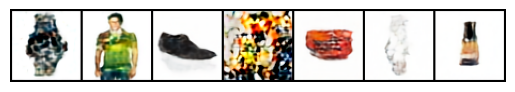

Epoch: 81/100 - loss: 6.56e+00, learning_rate: 8.55e-04


Epoch: 82/100 - loss: 6.47e+00, learning_rate: 7.72e-04


Epoch: 83/100 - loss: 6.35e+00, learning_rate: 6.93e-04


Epoch: 84/100 - loss: 6.42e+00, learning_rate: 6.17e-04


Epoch: 85/100 - loss: 6.42e+00, learning_rate: 5.45e-04


Epoch: 86/100 - loss: 6.34e+00, learning_rate: 4.77e-04


Epoch: 87/100 - loss: 6.25e+00, learning_rate: 4.13e-04


Epoch: 88/100 - loss: 6.21e+00, learning_rate: 3.54e-04


Epoch: 89/100 - loss: 6.29e+00, learning_rate: 2.98e-04


Epoch: 90/100 - loss: 6.32e+00, learning_rate: 2.47e-04


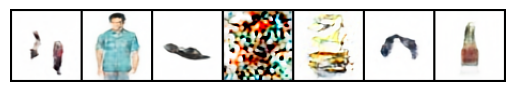

Epoch: 91/100 - loss: 6.33e+00, learning_rate: 2.01e-04


Epoch: 92/100 - loss: 6.23e+00, learning_rate: 1.59e-04


Epoch: 93/100 - loss: 6.21e+00, learning_rate: 1.22e-04


Epoch: 94/100 - loss: 6.16e+00, learning_rate: 8.99e-05


Epoch: 95/100 - loss: 6.07e+00, learning_rate: 6.26e-05


Epoch: 96/100 - loss: 6.28e+00, learning_rate: 4.01e-05


Epoch: 97/100 - loss: 6.35e+00, learning_rate: 2.26e-05


Epoch: 98/100 - loss: 6.23e+00, learning_rate: 1.00e-05


Epoch: 99/100 - loss: 6.11e+00, learning_rate: 2.51e-06


Epoch: 100/100 - loss: 6.20e+00, learning_rate: 2.01e-08


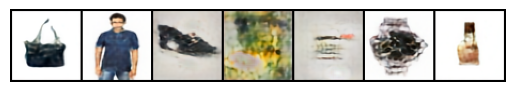

In [18]:
for epoch in range(total_epochs):
    model.train()

    avg_loss = 0.
    p_bar = progress_bar(train_loader, leave=False)
    for images, labels in p_bar:
        images = encode_images(images)
        labels = labels.cuda()
        
        with torch.autocast("cuda") and torch.enable_grad():
            # noised images
            t = torch.randint(low=1, high=noise_steps, size=(images.shape[0],)).cuda()
            x_t, noise = noise_images(images, t)
            # dropout
            if np.random.random() < 0.1:
                labels = None
            # forward pass
            predicted_noise = model(x_t, t, labels)
            # calculate loss
            loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.step_ema(ema_model, model)
        scheduler.step()
        # logger
        p_bar.comment = f"loss: {loss.item():.2e}, learning_rate: {scheduler.get_last_lr()[0]:.2e}"
        avg_loss += loss
    
    print(f"Epoch: {epoch + 1}/{total_epochs} - loss: {avg_loss.mean().item():.2e}, learning_rate: {scheduler.get_last_lr()[0]:.2e}")

    # callbacks
    if (epoch + 1) % log_every_epoch == 0:
        log_samples()
        save_checkpoint(checkpoint_path="sub_diffusion_models")

In [20]:
save_checkpoint(checkpoint_path="diffusion_models")

In [23]:
load_models(checkpoint_path="diffusion_models")

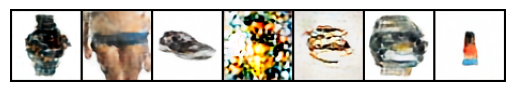

In [24]:
log_samples()